# Fine Tune CT-FM
* 3D Segmentation Model
* ULS DeepLesion 3D + AutoPET Dataset
* 750+ samples

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from lighter_zoo import SegResNet
from monai.transforms import LoadImage
from tqdm import tqdm

from setup_utils import get_inferer, get_preprocess, get_postprocess
from utils.plot import transparent_cmap

# load model
model_name = "project-lighter/whole_body_segmentation"
device = "cuda"
seg_model = SegResNet.from_pretrained(model_name).to(device)

# load pipelines
inferer = get_inferer(device)
preprocess = get_preprocess()
postprocess = get_postprocess(preprocess)

## Test Inference
Just to test out the model out of the box

In [3]:
import random
import SimpleITK as sitk

# load data from 3D dataset for nnUNet
data_folder = Path("/media/liushifeng/KINGSTON/nnUNet_raw/Dataset001_3dlesion")
train_images = data_folder / "imagesTr"
train_labels = data_folder / "labelsTr"

uls_img = [x for x in os.listdir(train_images) if x.startswith("ULS")]
ap_img = [x for x in os.listdir(train_images) if x.startswith("AutoPET")]
f = uls_img[0]
print(f)

# Load data
ct_path = train_images / f
seg_path = train_labels / f.replace("_0000.nii.gz", ".nii.gz")
# seg_data = sitk.GetArrayFromImage(sitk.ReadImage(seg_path))
# ct_data = sitk.GetArrayFromImage(sitk.ReadImage(ct_path))

ULSDL3D_003615_01_01_022_lesion_01_0000.nii.gz


In [4]:
input_tensor = preprocess(ct_path)
with torch.no_grad():
    output = inferer(input_tensor.unsqueeze(dim=0), seg_model.to(device))[0]
    print(f"{output.shape=}")

output.applied_operations = input_tensor.applied_operations
output.affine = input_tensor.affine
result = postprocess(output[0])
print(result.shape)

output.shape=torch.Size([1, 118, 47, 126, 126])
torch.Size([1, 256, 256, 128])


In [6]:
# load scan to visualize with masks
ct_img = LoadImage()(ct_path)

In [ ]:
# visualize
res = result.squeeze()
for i in range(0, res.shape[-1], 2):
    seg_mask = res[..., i].rot90()
    if (seg_mask > 0).sum() > 0:
        ct_slice = ct_img[:, :, i].rot90()
        fig, axes = plt.subplots(1, 2, figsize=(6, 3))
        axes[0].imshow(ct_slice, cmap="gray")
        axes[1].imshow(seg_mask, vmin=0, vmax=117, cmap="gist_stern")
        plt.show()
        break

## Fine-Tune

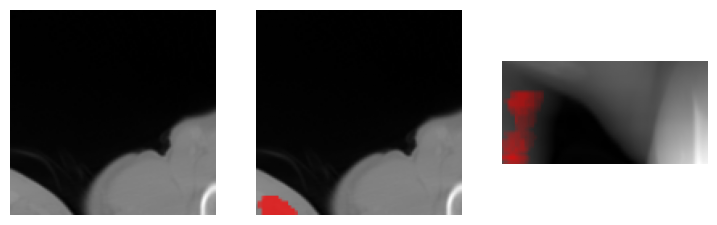

In [3]:
from torch.nn import Conv3d
from torch.utils.data import DataLoader
import numpy as np
from dataset import PatchDataset, get_train_val_paths, visualize_data


sw_ct_folder = Path("/media/liushifeng/KINGSTON/lesion3D/sliding_window/ct/")
sw_seg_folder = Path("/media/liushifeng/KINGSTON/lesion3D/sliding_window/seg/")
cent_ct_folder = Path("/media/liushifeng/KINGSTON/lesion3D/centroid/ct/")
cent_seg_folder = Path("/media/liushifeng/KINGSTON/lesion3D/centroid/seg/")

img_paths = [sw_ct_folder / x for x in os.listdir(sw_ct_folder)]
# img_paths = [cent_ct_folder / x for x in os.listdir(cent_ct_folder)]
split_json = "/media/liushifeng/KINGSTON/lesion3D/splits_final.json"

train_img_paths, val_img_paths = get_train_val_paths(img_paths, split_json)
train_seg_paths = [x.parents[1] / "seg" / x.name for x in train_img_paths]
val_seg_paths = [x.parents[1] / "seg" / x.name for x in val_img_paths]


bs = 4  # batch size
nw = 2  # number of workers

# data loaders
train_dataset = PatchDataset(train_img_paths, train_seg_paths)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=nw)

val_dataset = PatchDataset(val_img_paths, val_seg_paths)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=nw)


# visualize dataset
d = next(iter(train_loader))
x, y = d['img'], d['seg']
z = y[0].sum(dim=(2,3)).argmax()  # get slice with the most lesion label

visualize_data(x, y, z)

### Training Loop

In [4]:
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from model import Seg3dNet

# change out_channel of heads
for i in range(len(seg_model.up_layers)):
    h = seg_model.up_layers[i].head
    seg_model.up_layers[i].head = Conv3d(h.in_channels, 1, h.kernel_size, h.stride)
net = Seg3dNet(seg_model)
#### net = torch.compile(net)

In [7]:
early_stopping = EarlyStopping('val_loss', patience=50, verbose=True)
logger = TensorBoardLogger("lightning_logs", name="Seg3dNet", version="sw_bce1e3")
trainer = L.Trainer(
    max_epochs=500,
    callbacks=[early_stopping],
    logger=logger,
    num_sanity_val_steps=2,
)
trainer.fit(net, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/liushifeng/.cache/pypoetry/virtualenvs/ctseg-7dVpZyTM-py3.12/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory lightning_logs/Seg3dNet/sw_bce1e3/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | model      | SegResNet         | 87.2 M | train
1 | dice_score | DiceScore         | 0      | train
2 | iou        | MeanIoU           | 0      | train
3 | mse        | MeanSquaredError  | 0      | train
4 | bce        | BCEWithLogitsLoss | 0      | train
5 | dice       | DiceLoss          | 0      | train
---------------------------------------------------------
87.2 M    Trainable params
0         Non-trainable params
87.2 M    Total params
348.655   Total estimated model params 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [6]:
# load checkpoint
net = Seg3dNet.load_from_checkpoint("lightning_logs/Seg3dNet/sw_train_fixed_loss/checkpoints/epoch=1-step=6644-v1.ckpt", model=seg_model).to(device)
net.model.eval();

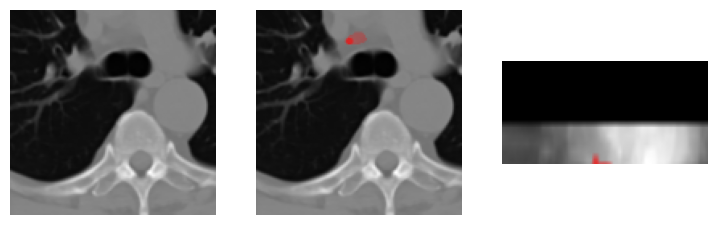

In [10]:
# visualize input and output (first item in batch only)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True, num_workers=nw)
d = next(iter(val_loader))
x, y = d['img'], d['seg']
z = y[0].sum(dim=(2,3)).argmax()  # get slice with the most lesion label

visualize_data(x, y, z)

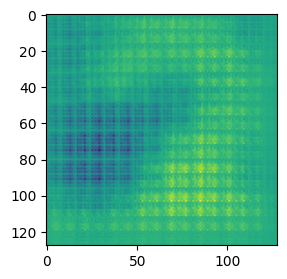

In [11]:
# infer and plot outputs
net = net.to(device)
out = net(x.float().to(device))
plt.figure(figsize=(3,3))
plt.imshow(out[0][0].cpu().squeeze().detach()[z])

### Data processing

In [ ]:
# select sample
from patching import sample_points, get_lesion_patch
import random
import cc3d


f = random.sample(uls_img, 1)[0]
# f = "AutoPET-Lymphoma-B_PETCT_0fa313309d_CT_0000.nii.gz"
f = "ULSDL3D_000441_02_01_187_lesion_01_0000.nii.gz"

# load CT and seg
ct_path = train_images / f
ct_img = sitk.ReadImage(ct_path)
ct_data = sitk.GetArrayFromImage(ct_img)

seg_path = train_labels / f.replace("_0000.nii.gz", ".nii.gz")
seg_img = sitk.ReadImage(seg_path)
seg_data = sitk.GetArrayFromImage(seg_img)
spacing = seg_img.GetSpacing()

# get connected components in seg
labels, n_components = cc3d.connected_components(seg_data, return_N=True)

# sample points within cc
for c in range(1, n_components + 1):
    coords = np.argwhere(labels == c)
    points = sample_points(coords)
    for point in points:
        # crop volume around the point
        seg_patch = get_lesion_patch(seg_data, point, spacing)
        ct_patch = get_lesion_patch(ct_data, point, spacing)
        print(f"{f[:10]} {c=} {point=}")